# Diluted Unitary Fitting, Analysis

In [1]:
import sys
sys.path.insert(0, '../../src_tf/')

import numpy as np
import qiskit as qk
import matplotlib.pyplot as plt
import multiprocessing as mp
import random
import pickle

from qiskit.quantum_info import DensityMatrix, random_unitary
from qiskit.quantum_info import Operator
from scipy.linalg import sqrtm
from tqdm.notebook import tqdm
from math import ceil

from loss_functions import *
from optimization import *
from quantum_channel import *
from kraus_channels import *
from quantum_tools import *
from experimental import *
from spam import *
from scipy.stats import gaussian_kde
from quantum_circuits import *
from analysis import *
from utils import *

#np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=4)

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [16]:
def resample_diluted(diluted_model, num_samples, rng):
    d = diluted_model.channel.d
    c = diluted_model.channel.c
    rank = diluted_model.channel.rank
    for i in range(num_samples):
        diluted_resample = DilutedKrausMap(U=generate_haar_random(d, rng=rng), c=c, kraus_part=KrausMap(d, rank = rank))
        spectrum_resample = channel_spectrum(diluted_resample, use_coords=True, keep_real=False)
        spectrum_resample_list.append(spectrum_resample)
    
    spectrum_resample = np.real(np.concatenate(spectrum_resample_list))
    
    return spectrum_resample

In [24]:
[channel_list1, channel_list2, channel_list3, channel_list4, channel_list5, channel_list6, channel_list7] = loader(data_path("channel_fullRank_belem_longTrain.p"))

spectrum_target_list1 = [channel_spectrum(channel, use_coords=True) for channel in channel_list1]
spectrum_target_list2 = [channel_spectrum(channel, use_coords=True) for channel in channel_list2]
spectrum_target_list3 = [channel_spectrum(channel, use_coords=True) for channel in channel_list3]
spectrum_target_list4 = [channel_spectrum(channel, use_coords=True) for channel in channel_list4]
spectrum_target_list5 = [channel_spectrum(channel, use_coords=True) for channel in channel_list5]
spectrum_target_list6 = [channel_spectrum(channel, use_coords=True) for channel in channel_list6]
spectrum_target_list7 = [channel_spectrum(channel, use_coords=True) for channel in channel_list7]

In [14]:
[distance_best_list1, model_best_list1] = loader(data_path("diluted_fitting_8layer.model"))
[distance_best_list2, model_best_list2] = loader(data_path("diluted_fitting_16layer.model"))
[distance_best_list3, model_best_list3] = loader(data_path("diluted_fitting_24layer.model"))
[distance_best_list4, model_best_list4] = loader(data_path("diluted_fitting_32layer.model"))
[distance_best_list5, model_best_list5] = loader(data_path("diluted_fitting_40layer.model"))
[distance_best_list6, model_best_list6] = loader(data_path("diluted_fitting_48layer.model"))
[distance_best_list7, model_best_list7] = loader(data_path("diluted_fitting_56layer.model"))

In [3]:
spectrum_diluted_list1 = [channel_spectrum(model.channel, use_coords=True) for model in model_best_list1]
spectrum_diluted_list2 = [channel_spectrum(model.channel, use_coords=True) for model in model_best_list2]
spectrum_diluted_list3 = [channel_spectrum(model.channel, use_coords=True) for model in model_best_list3]
spectrum_diluted_list4 = [channel_spectrum(model.channel, use_coords=True) for model in model_best_list4]
spectrum_diluted_list5 = [channel_spectrum(model.channel, use_coords=True) for model in model_best_list5]
spectrum_diluted_list6 = [channel_spectrum(model.channel, use_coords=True) for model in model_best_list6]
spectrum_diluted_list7 = [channel_spectrum(model.channel, use_coords=True) for model in model_best_list7]

In [4]:
print(f"Mean Error, Std Error, Max Error, Min Error")
print(f"{np.mean(distance_best_list1):.4f}, {np.std(distance_best_list1):.4f}, {np.max(distance_best_list1):.4f}, {np.min(distance_best_list1):.4f}")
print(f"{np.mean(distance_best_list2):.4f}, {np.std(distance_best_list2):.4f}, {np.max(distance_best_list2):.4f}, {np.min(distance_best_list2):.4f}")
print(f"{np.mean(distance_best_list3):.4f}, {np.std(distance_best_list3):.4f}, {np.max(distance_best_list3):.4f}, {np.min(distance_best_list3):.4f}")
print(f"{np.mean(distance_best_list4):.4f}, {np.std(distance_best_list4):.4f}, {np.max(distance_best_list4):.4f}, {np.min(distance_best_list4):.4f}")
print(f"{np.mean(distance_best_list5):.4f}, {np.std(distance_best_list5):.4f}, {np.max(distance_best_list5):.4f}, {np.min(distance_best_list5):.4f}")
print(f"{np.mean(distance_best_list6):.4f}, {np.std(distance_best_list6):.4f}, {np.max(distance_best_list6):.4f}, {np.min(distance_best_list6):.4f}")
print(f"{np.mean(distance_best_list7):.4f}, {np.std(distance_best_list7):.4f}, {np.max(distance_best_list7):.4f}, {np.min(distance_best_list7):.4f}")

Mean Error, Std Error, Max Error, Min Error
0.0077, 0.0061, 0.0247, 0.0024
0.0036, 0.0013, 0.0058, 0.0021
0.0035, 0.0011, 0.0057, 0.0020
0.0054, 0.0070, 0.0204, 0.0009
0.0053, 0.0028, 0.0125, 0.0014
0.0033, 0.0024, 0.0084, 0.0006
0.0055, 0.0065, 0.0240, 0.0008


## Diluted Unitary Histogram Overlay

In [ ]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
rng = np.random.default_rng(seed=42)

spectrum_resample_list = []
for diluted_model in tqdm(model_best_list1):
    spectrum_resample = resample_diluted(diluted_model, num_samples = 1000, rng=rng)
    spectrum_resample_list.append(spectrum_resample)
    
spectrum_resample = np.concatenate(spectrum_resample_list)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
fig = plt.figure(figsize=(4,4), dpi = 300, facecolor='w', edgecolor='k')

plt.hist2d(spectrum_resample[:,0], spectrum_resample[:,1], bins = np.linspace(-1, 1, 100))
for spectrum in spectrum_target_list:
    plt.plot(spectrum[:,0], spectrum[:,1], "ro", markersize=0.5)
plt.show()

In [19]:
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
rng = np.random.default_rng(seed=42)

spectrum_resample_list = []
for diluted_model in tqdm(model_best_list2):
    spectrum_resample = resample_diluted(diluted_model, num_samples = 1000, rng=rng)
    spectrum_resample_list.append(spectrum_resample)
    
spectrum_resample = np.concatenate(spectrum_resample_list)

  0%|          | 0/10 [00:00<?, ?it/s]

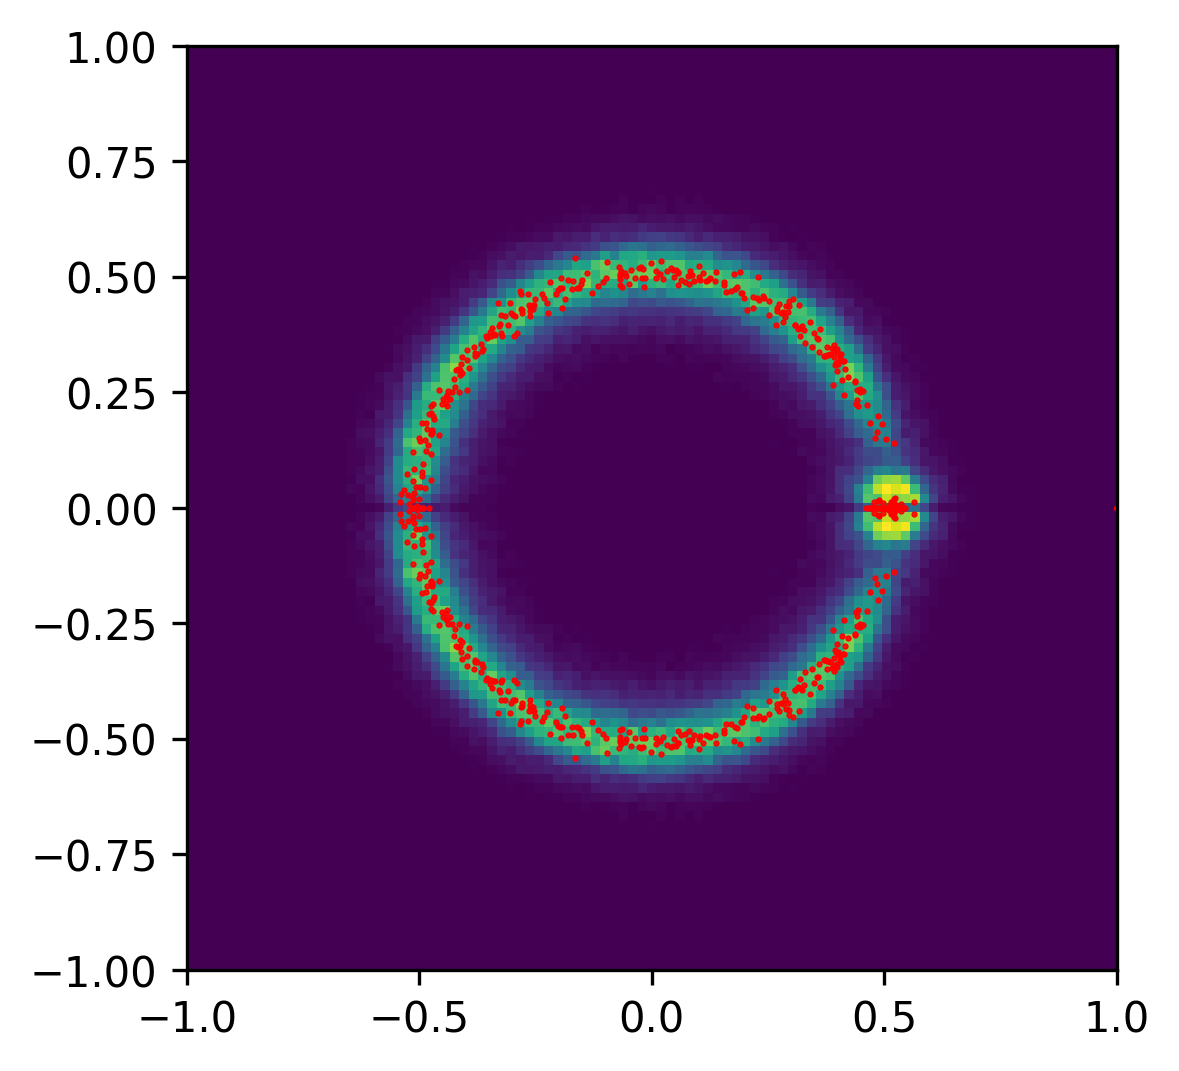

In [26]:
fig = plt.figure(figsize=(4,4), dpi = 300, facecolor='w', edgecolor='k')

plt.hist2d(spectrum_resample[:,0], spectrum_resample[:,1], bins = np.linspace(-1, 1, 100))
for spectrum in spectrum_target_list2:
    plt.plot(spectrum[:,0], spectrum[:,1], "ro", markersize=0.5)
plt.show()

## Four Qubits

In [4]:
[model1, model2, model3, model4, model5] = loader(data_path("belem_4qubit_repeated.model"))

spectrum1 = channel_spectrum(model1.channel, use_coords=True, keep_real=False)
spectrum2 = channel_spectrum(model2.channel, use_coords=True, keep_real=False) 
spectrum3 = channel_spectrum(model3.channel, use_coords=True, keep_real=False)
spectrum4 = channel_spectrum(model4.channel, use_coords=True, keep_real=False)
spectrum5 = channel_spectrum(model5.channel, use_coords=True, keep_real=False)

In [5]:
n = 4
d = 2**n

rank_grid = np.arange(8, 11)

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
U = tf.cast(Operator(random_unitary(d).data), dtype=precision)
distance_best, model_best = optimize_annulus_distance(spectrum1, U, rank_grid)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

0.08600489164413189 None
0.024804599230282068 None
0.024595133658834083 None
0.028622137543561944 None
0.0287881115835765 None
0.02584006668719141 None


  0%|          | 0/500 [00:00<?, ?it/s]

0.08373255380836753 None
0.025840297533223984 None
0.021948208707364195 None
0.022751749170682727 None
0.022188533826799882 None
0.0222486145421751 None


  0%|          | 0/500 [00:00<?, ?it/s]

0.08326577648838719 None
0.021189401223754404 None
0.024855162942603336 None
0.024918534924607556 None
0.020994909028617243 None
0.025212998219739154 None


tf.Tensor(0.4307751801759259, shape=(), dtype=float64) 9


  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\krist\anaconda3\envs\env_qiskit\lib\site-packages\matplotlib\cbook\__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


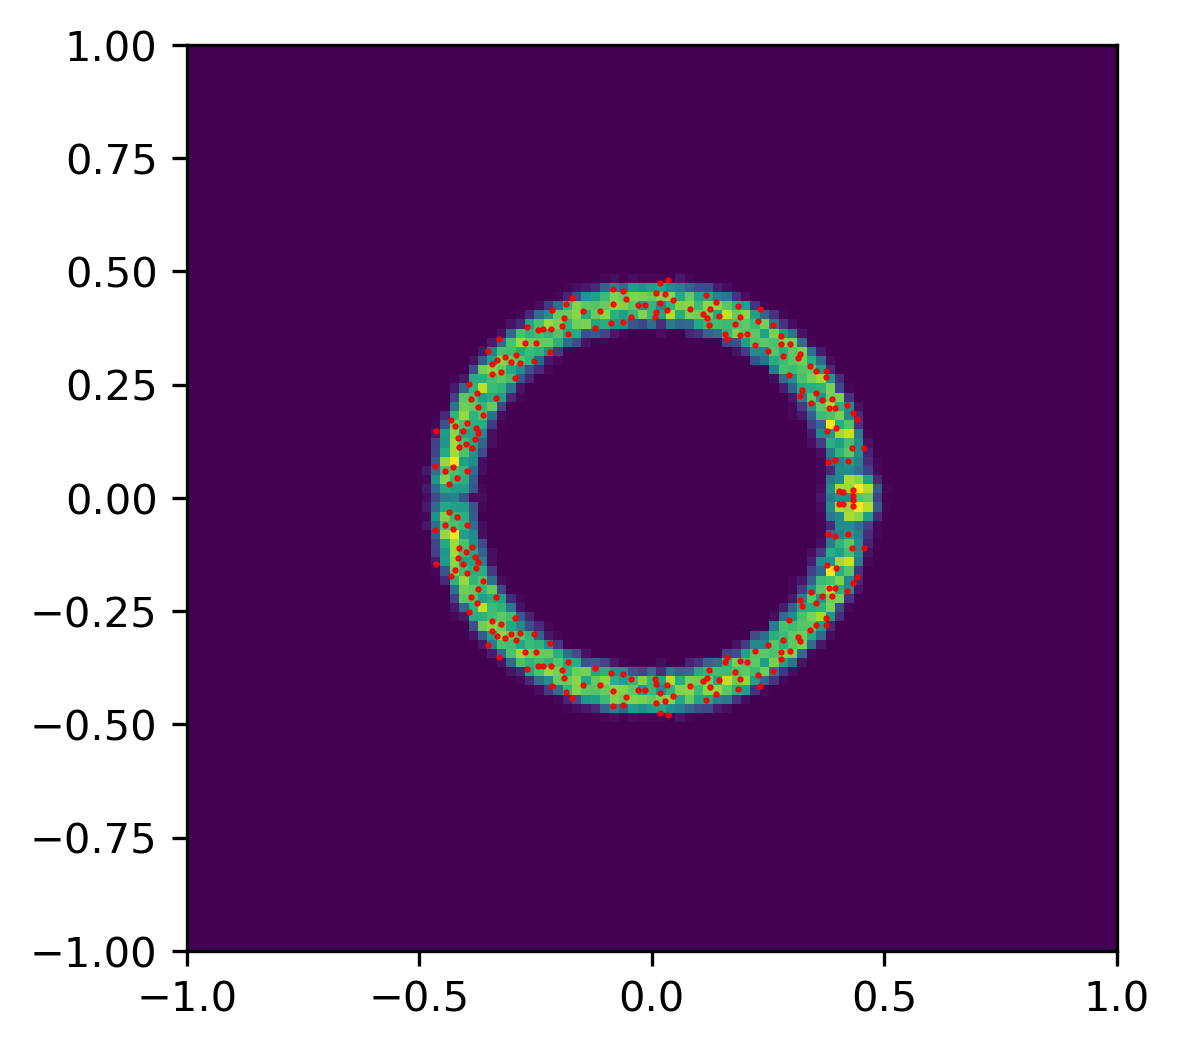

In [6]:
c = model_best.channel.c
rank = model_best.channel.kraus_part.rank
print(c, rank)
spectrum_list = []

for i in tqdm(range(100)):
    U = tf.cast(Operator(random_unitary(d).data), dtype=precision)
    diluted = DilutedKrausMap(U=U, c=c, kraus_part=KrausMap(d, rank=rank))
    spectrum = channel_spectrum(diluted, use_coords=True, keep_real=False)
    spectrum_list.append(spectrum)

spectrum = np.real(np.concatenate(spectrum_list))

fig = plt.figure(figsize=(4,4), dpi = 300, facecolor='w', edgecolor='k')

plt.hist2d(spectrum[:,0], spectrum[:,1], bins = np.linspace(-1, 1, 100))
plt.plot(spectrum1[:,0], spectrum1[:,1], "ro", markersize=0.5)
plt.show()

In [14]:
n = 4
d = 2**n

rank_grid = np.arange(50, 80, 10)

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)
U = tf.cast(Operator(random_unitary(d).data), dtype=precision)
distance_best, model_best = optimize_annulus_distance(spectrum4, U, rank_grid)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

0.4088218666709118 None
0.20206418795355624 None
0.09334149227577132 None
0.06296902123073685 None
0.051251770728200106 None
0.058143917141411046 None


  0%|          | 0/500 [00:00<?, ?it/s]

0.4085640250198402 None
0.2004326799249838 None
0.09128587614236457 None
0.05741106953133503 None
0.05358584535814646 None
0.05746447375656355 None


  0%|          | 0/500 [00:00<?, ?it/s]

0.4089498117197646 None
0.20067477505470266 None
0.08920279041892847 None
0.05240906016984666 None
0.051127647575668976 None
0.04717401130685926 None


tf.Tensor(0.09838013176878789, shape=(), dtype=float64) 70


  0%|          | 0/100 [00:00<?, ?it/s]

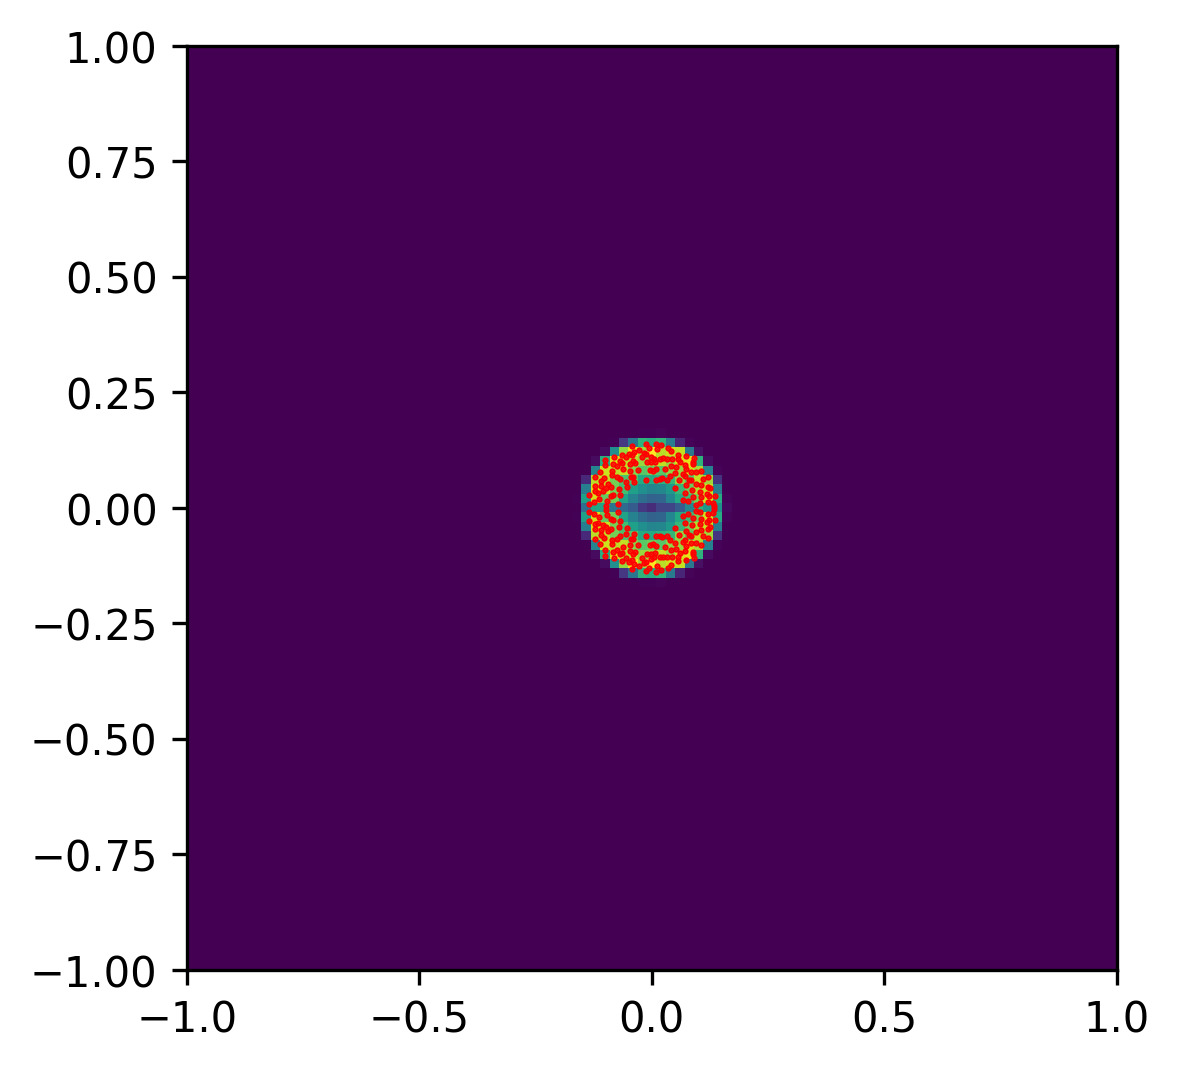

In [16]:
c = model_best.channel.c
rank = model_best.channel.kraus_part.rank
print(c, rank)

spectrum_list = []

for i in tqdm(range(100)):
    U = tf.cast(Operator(random_unitary(d).data), dtype=precision)
    diluted = DilutedKrausMap(U=U, c=c, kraus_part=KrausMap(d, rank=rank))
    spectrum = channel_spectrum(diluted, use_coords=True, keep_real=False)
    spectrum_list.append(spectrum)

spectrum = np.real(np.concatenate(spectrum_list))

fig = plt.figure(figsize=(4,4), dpi = 300, facecolor='w', edgecolor='k')

plt.hist2d(spectrum[:,0], spectrum[:,1], bins = np.linspace(-1, 1, 100))
plt.plot(spectrum4[:,0], spectrum4[:,1], "ro", markersize=0.5)
plt.show()